# Test Performances

Notebook to analyse test performances, including :
- full-disk level performances
- patch/sector level performances
- center vs. limb pathes performances
- performances on windows where the activity differes from the previous one (AC-windows)
- performances on windows where the activity is the same as the previous one (NC-windows)
- persistent relative metrics

# Config

In [1]:
COLAB = False

if COLAB : 
  configSetup = {
      'COLAB'           : 'True',
      'PATH_ROOT_DRIVE' : '/content/drive/MyDrive/Projects/Forecast',
      'PATH_ROOT_LOCAL' : '/content/session',
      'PATH_SUNDL'      : '/content/sundl',
      'PATH_PROJECT'    : '/content/flare_limits_pcnn'
  }
  !git clone https://github.com/gfrancisco20/sundl.git
  !git clone https://github.com/gfrancisco20/flare_limits_pcnn.git
  import sys
  import re
  sys.path.append(configSetup['PATH_SUNDL'])
  sys.path.append(configSetup['PATH_PROJECT'])
  configFile = f'{configSetup["PATH_PROJECT"]}/config.py'
  with open(configFile, 'r') as file:
    content = file.read()
  for constant in configSetup.keys():
    content = re.sub(re.compile(f'{constant} = .*'), f'{constant} = \'{configSetup[constant]}\'', content)
  with open(configFile, 'w') as file:
    file.write(content)
   
from config import *
if COLAB:
  from sundl.utils.colab import mountDrive
  # mouting drive content in session on colab
  mountDrive()
  
# you must request the prediction  files  or recompute  them with folder 3  to run this  notebook

# Libraries

In [2]:
from glob import glob
import dill as pickle

import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sundl.utils.data import read_Dataframe_With_Dates

2024-04-19 19:33:56.922254: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Setup

In [3]:
FOLDER = PATH_RES/'Results' 

modelDict = {
  'C+_mpf_Persistent_24'                                        : 'C+_Persistent',
  'C+_mpf_jpg_PTx8_RtdXall_EquiC_AW1e5D1e4_blos_24'          : 'C+_PCNN_Blos', #
  'C+_mpf_jpg_PTx8_RtdXall_EquiC_AW1e5D1e4_0193x0211x0094_24': 'C+_PCNN_EUV',
  'M+_mpf_Persistent_24'                                        : 'M+_Persistent',
  'M+_mpf_jpg_PTx8_RtdXall_LowC2_AW1e5D1e4_0193x0211x0094_24': 'M+_PCNN_EUV',
  'M+_mpf_jpg_PTx8_RtdXall_LowC2_AW1e5D1e4_blos_24'          : 'M+_PCNN_Blos',
  'C+_PCNN_Both_Max'                                       : 'C+_PCNN_Both_Max',
  'M+_PCNN_Both_Max'                                       : 'M+_PCNN_Both_Max', 
  'C+_PCNN_Both_Avg'                                       : 'C+_PCNN_Both_Avg',
  'M+_PCNN_Both_Avg'                                       : 'M+_PCNN_Both_Avg' 
}

modelDictRev = {modelDict[oldName] : oldName for oldName in modelDict.keys()}

sns.set(style="whitegrid")

# Full Disk Performances

## Load predictions

In [4]:
%%time
from config import F_PATH_PREDS_MODEL
fdPredictions = {}
for modelNameFull in modelDict.keys():
  modelName = modelNameFull # modelDict[modelNameFull]
  pathPredFd_withLabels = F_PATH_PREDS_MODEL(F_PATH_PREDS(FOLDER), modelName, 'fd', True)
  if pathPredFd_withLabels.exists():
    fdPredictions[modelName] = read_Dataframe_With_Dates(pathPredFd_withLabels)
  else:
    pathPredFd = F_PATH_PREDS_MODEL(F_PATH_PREDS(FOLDER), modelName, 'fd', False)
    if pathPredFd.exists():
      fdPredictions[modelName] = read_Dataframe_With_Dates(pathPredFd)
      fdPredictions[modelName]['histo'] = fdPredictions[modelName]['label'].rolling(window = f'{24}H',
                                        closed = 'right', # min_periods = int(input_lag)
                                        ).apply(
                                          lambda x: x[0])
      fdPredictions[modelName]['change'] = fdPredictions[modelName]['histo'] != fdPredictions[modelName]['label']
      fdPredictions[modelName].to_csv(pathPredFd_withLabels)

<timed exec>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<timed exec>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<timed exec>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<timed exec>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<tim

CPU times: user 12.5 s, sys: 427 ms, total: 13 s
Wall time: 21.8 s


## Compute Performances

In [6]:
%%time
from utilsTest import fullDiskPerformance

startingDates = [datetime.datetime(2020,1,28)]
filterNames   = ['all','windowChanging', 'windowConstant']
includeFolds  = True

perfTest = fullDiskPerformance(fdPredictions, 
                               startingDates, 
                               filterNames, 
                               includeFolds)

/Users/greg/Projects/flare_limits_pcnn/utilsTest.py:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perfTest = pd.concat([perfTest,pd.DataFrame({


/Users/greg/Projects/flare_limits_pcnn/utilsTest.py:144: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2*prec*rec / (prec+rec)
/Users/greg/Projects/flare_limits_pcnn/utilsTest.py:144: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2*prec*rec / (prec+rec)


CPU times: user 1.29 s, sys: 39.5 ms, total: 1.33 s
Wall time: 2 s


### Standard Metrics

In [10]:
viz = perfTest.copy()[perfTest.modelFdId == 'avg']
viz = viz[viz['startingDate']==viz['startingDate'].min()]

col = ['filter','tss', 'hss', 'mcc', 'f1',  'recall', 'far', 'bal_pos', 'switch_rate', 'fssp', 'fssr' ,'acc_w']

# viz[viz['filter']=='all'].sort_values(['tss'], ascending = False)[col]

modelsTab = ['C+_Persistent' ,'C+_PCNN_EUV', 'C+_PCNN_Blos', #'C+_PCNN_Both_Avg', 'C+_PCNN_Both_Max',
             'M+_Persistent' ,'M+_PCNN_EUV', 'M+_PCNN_Blos', #'M+_PCNN_Both_Avg', 'M+_PCNN_Both_Max',
             ]
modelsTab =  [modelDictRev[m] for m in modelsTab]

viz[viz['filter']=='all'].set_index('model').loc[modelsTab,col]

,filter,tss,hss,mcc,f1,recall,far,bal_pos,switch_rate,fssp,fssr,acc_w
model,,,,,,,,,,,,
C+_mpf_Persistent_24,all,0.743970,0.744005,0.744006,0.867999,0.867301,0.131301,0.484752,0.127872,-0.000122,0.740024,0.871985
C+_mpf_jpg_PTx8_RtdXall_EquiC_AW1e5D1e4_0193x0211x0094_24,all,0.736978,0.739210,0.742446,0.859010,0.817778,0.095379,0.483767,0.127714,-0.010357,0.722598,0.868489
C+_mpf_jpg_PTx8_RtdXall_EquiC_AW1e5D1e4_blos_24,all,0.670735,0.669850,0.675969,0.824663,0.769780,0.112026,0.504919,0.131786,-0.051563,0.647602,0.835368
M+_mpf_Persistent_24,all,0.491321,0.491321,0.491321,0.560912,0.560912,0.439088,0.136809,0.120142,0.000000,0.440771,0.745660
M+_mpf_jpg_PTx8_RtdXall_LowC2_AW1e5D1e4_0193x0211x0094_24,all,0.611569,0.416530,0.463758,0.525310,0.817850,0.613086,0.137318,0.119974,-0.067197,0.394943,0.805785
M+_mpf_jpg_PTx8_RtdXall_LowC2_AW1e5D1e4_blos_24,all,0.580363,0.369192,0.429525,0.497065,0.838895,0.646839,0.144026,0.125929,-0.116840,0.352193,0.790182


### AC - metrics

In [11]:
viz[viz['filter']=='windowChanging'].set_index('model').loc[modelsTab,col]

,filter,tss,hss,mcc,f1,recall,far,bal_pos,switch_rate,fssp,fssr,acc_w
model,,,,,,,,,,,,
C+_mpf_Persistent_24,windowChanging,-1.000000,-0.999926,-1.000000,NaN,0.000000,1.000000,0.503050,1.0,NaN,NaN,0.000000
C+_mpf_jpg_PTx8_RtdXall_EquiC_AW1e5D1e4_0193x0211x0094_24,windowChanging,0.120354,0.120044,0.125301,0.490272,0.420467,0.412131,0.504489,1.0,0.485696,-0.023818,0.560177
C+_mpf_jpg_PTx8_RtdXall_EquiC_AW1e5D1e4_blos_24,windowChanging,0.031505,0.031390,0.033907,0.407227,0.330700,0.470163,0.504843,1.0,0.401485,-0.189452,0.515753
M+_mpf_Persistent_24,windowChanging,-1.000000,-1.000000,-1.000000,NaN,0.000000,1.000000,0.500000,1.0,NaN,NaN,0.000000
M+_mpf_jpg_PTx8_RtdXall_LowC2_AW1e5D1e4_0193x0211x0094_24,windowChanging,0.082318,0.082712,0.090290,0.623274,0.746163,0.464860,0.505974,1.0,0.618773,0.242047,0.541159
M+_mpf_jpg_PTx8_RtdXall_LowC2_AW1e5D1e4_blos_24,windowChanging,0.054234,0.054428,0.061284,0.619094,0.759763,0.477624,0.503876,1.0,0.616141,0.235234,0.527117


### NC - metrics

In [12]:
viz[viz['filter']=='windowConstant'].set_index('model').loc[modelsTab,col]

,filter,tss,hss,mcc,f1,recall,far,bal_pos,switch_rate,fssp,fssr,acc_w
model,,,,,,,,,,,,
C+_mpf_Persistent_24,windowConstant,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.482069,0.0,0.000000,1.000000,1.000000
C+_mpf_jpg_PTx8_RtdXall_EquiC_AW1e5D1e4_0193x0211x0094_24,windowConstant,0.828666,0.830731,0.832474,0.909284,0.878824,0.058069,0.480733,0.0,-0.090716,0.822063,0.914333
C+_mpf_jpg_PTx8_RtdXall_EquiC_AW1e5D1e4_blos_24,windowConstant,0.767758,0.767023,0.770667,0.878712,0.836417,0.074488,0.504930,0.0,-0.121288,0.756227,0.883879
M+_mpf_Persistent_24,windowConstant,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.087216,0.0,0.000000,1.000000,1.000000
M+_mpf_jpg_PTx8_RtdXall_LowC2_AW1e5D1e4_0193x0211x0094_24,windowConstant,0.702125,0.398567,0.467784,0.474860,0.874649,0.674102,0.087059,0.0,-0.525140,0.383424,0.851062
M+_mpf_jpg_PTx8_RtdXall_LowC2_AW1e5D1e4_blos_24,windowConstant,0.677875,0.348760,0.434030,0.439545,0.901212,0.709348,0.092182,0.0,-0.560455,0.336218,0.838937


## Box Plot (Test & CV)

### Setup

In [13]:
metrics = ['tss','hss', 'mcc','f1']

modelOrder = {'C+_Persistent\nValidation' : 0,
              'C+_PCNN_Blos\nValidation' : 1,
              'C+_PCNN_Blos\nOperational Test\n(CV folds models)' : 2,
              'C+_PCNN_EUV\nValidation' : 3,
              'C+_PCNN_EUV\nOperational Test\n(CV folds models)' : 4,
              'M+_Persistent\nValidation' : 0,
              'M+_PCNN_Blos\nValidation' : 1,
              'M+_PCNN_Blos\nOperational Test\n(CV folds models)' : 2,
              'M+_PCNN_EUV\nValidation' : 3,
              'M+_PCNN_EUV\nOperational Test\n(CV folds models)' : 4,
              }
modelsBoxPlot = list(set([modelDictRev[model.split('\n')[0]] for model in modelOrder.keys()]))


# Dataframe for test bp
perfs = perfTest[perfTest['filter']=='all'].reset_index().copy()
perfs = perfs[perfs['startingDate']==perfs['startingDate'].min()]
dfBp = pd.DataFrame({col:[] for col in ['model', 'fold','performance', 'metric']})
for i in range(len(perfs)):
  for mtc in metrics:
    fold = perfs.loc[i,'modelFdId']
    model = perfs.loc[i,'model']
    if fold not in ['']:#['fd000']:
      perf = perfs.loc[i,mtc]
      tmp = pd.DataFrame({'model' : model,
                          'fold' : fold,
                          'performance' : perf,
                          'metric' : mtc
                          },index = [len(dfBp)])
      dfBp = pd.concat([dfBp,tmp],axis=0)

dfBp = dfBp[dfBp['model'].isin(modelsBoxPlot)]

# Dataframe for val bp
dfBp_val = {'model':[],
            'performance' : [],
            'metric' : [],
            'fold' : []
            }
for modelName in modelsBoxPlot:
  foldsPaths = sorted(glob((FOLDER/f'training_folds/training_{modelName}*').as_posix()))
  for kf,fdPath in enumerate(foldsPaths):
    for i,mtc in enumerate(metrics):
      mtc = f'val_{mtc}'
      tmp = pd.read_csv(fdPath)
      tp = tmp['val_TP']
      tn = tmp['val_TN']
      fp = tmp['val_FP']
      fn = tmp['val_FN']
      tmp['val_mcc'] = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
      dfBp_val['model'].append(modelName)
      # print(dfBp_val['model'])
      #dfBp[mtc1].append(np.max(tmp[mtc1]))
      #dfBp[mtc2].append(tmp[mtc2].loc[np.argmax(tmp[mtc1])])
      if i==0:
        epc = np.argmax(tmp[mtc])
        dfBp_val['performance'].append(np.max(tmp[mtc]))
        # dfBp_val['epoch'].append(epc)
      else:
        dfBp_val['performance'].append(tmp[mtc].loc[epc])
        # dfBp_val['epoch'].append(epc)
      dfBp_val['metric'].append(mtc[4:])
      dfBp_val['fold'].append(kf)
dfBp_val = pd.DataFrame(dfBp_val)

# for modelName in modelDict.keys():
#   dfBp_val[dfBp_val['model'] == modelName]['model'] = modelDict[modelName] + '\nValidation'
dfBp_val['model'] = dfBp_val['model'].apply(lambda x: modelDict[x] + '\nValidation')
dfBp_val['fold'] = dfBp_val['fold'].apply(lambda x: str(x))
# dfBp_val

# Merging Test and Val
dfTest = dfBp.copy()
dfTest = dfTest[~dfTest['model'].isin(['C+_mpf_Persistent_24', 'M+_mpf_Persistent_24'])]
dfTest['model'] = dfTest['model'].apply(lambda x: modelDict[x] + '\nOperational Test\n(CV folds models)')
cls = dfTest['model'].reset_index()['model'][0][0]

dfAll = pd.concat([dfBp_val,dfTest],axis=0)
dfAll['order'] = dfAll['model'].apply(lambda x: modelOrder[x])
dfAll = dfAll.sort_values(by=['order'], ascending = True)

dfAll = dfAll[dfAll['metric'].isin(metrics)]


### C+

/var/folders/2f/7x2b25l505v3y0t1yrc6rybm0000gn/T/ipykernel_5166/2114163693.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  means = tmp.groupby(['model'])['performance'].mean()[0]#.sort_index(key=lambda x: x.map(modelsOrder))
/var/folders/2f/7x2b25l505v3y0t1yrc6rybm0000gn/T/ipykernel_5166/2114163693.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stds = tmp.groupby(['model'])['performance'].std()[0]#.sort_index(key=lambda x: x.map(modelsOrder))
/var/folders/2f/7x2b25l505v3y0t1yrc6rybm0000gn/T/ipykernel_5166/2114163693.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a fut

Text(0.5, 1.0, 'C+ models scores on Cross-Validation and Operational Test')

/Users/greg/Projects/sundl/.conda/lib/python3.11/site-packages/matplotlib/text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
/Users/greg/Projects/sundl/.conda/lib/python3.11/site-packages/matplotlib/text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


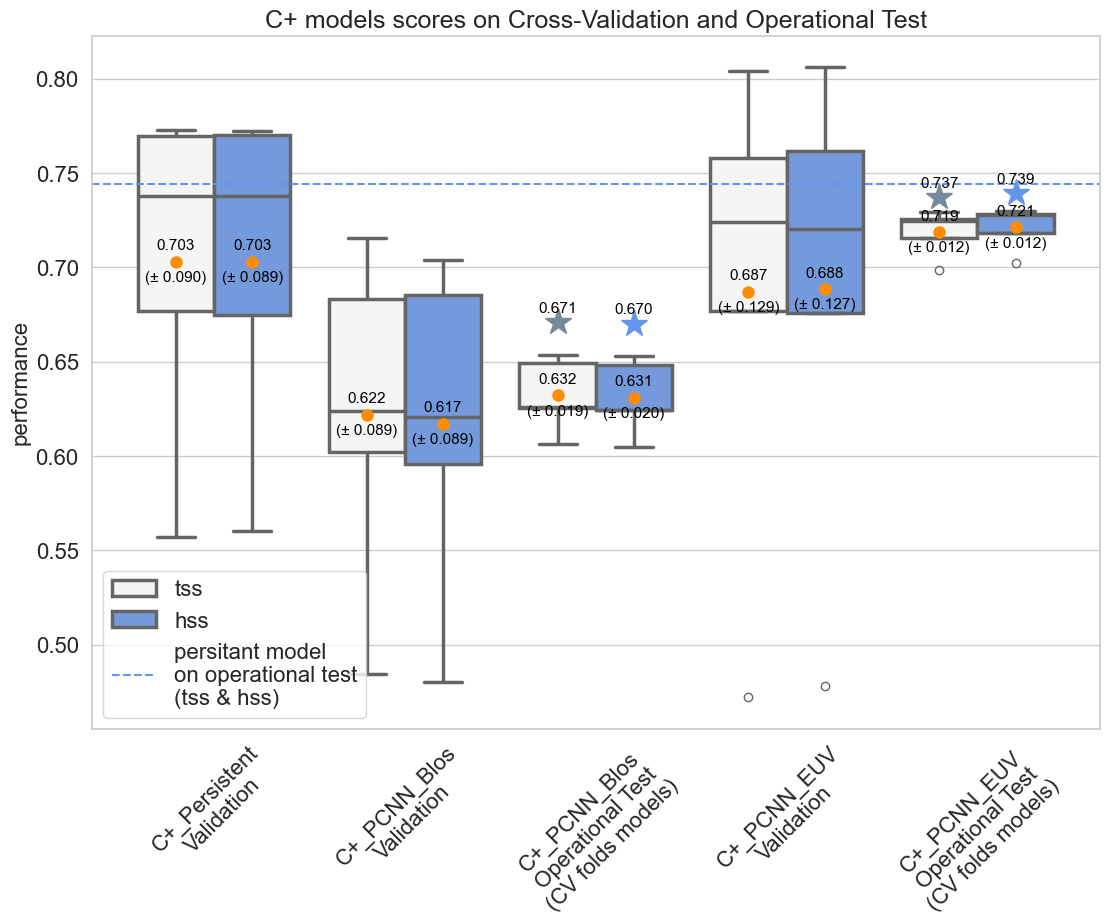

In [14]:
typeModel = 'C+'
metrics = ['tss','hss']
palette= ['whitesmoke','cornflowerblue']

dfTemp = dfAll.copy()
dfTemp = dfAll[dfAll['model'].apply(lambda x: x.split('_')[0]==typeModel)]


sns.set(style="whitegrid")

plt.rcParams["figure.figsize"] = (13,9)
fontsize = 16
plt.rcParams['font.size'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize


cls = dfTemp['model'].reset_index()['model'][0][0]

color = 'silver' # 'lightblue' 'cornflowerblue'

box_plot = sns.boxplot(x = 'model', y = 'performance', hue='metric',
            data = dfTemp[dfTemp['fold']!='avg'].sort_values(by=['order'], ascending = True),
            hue_order=metrics,
            dodge=True,
            linewidth=2.5,
            # palette= sns.color_palette([color]) ,#"Blues",#
            # color = 'cornflowerblue',
            palette= palette,
            showmeans = True,
            meanprops={"marker":"o",
                      "markerfacecolor":"darkorange",
                      "markeredgecolor":"darkorange",
                      "markersize":"8"}
)

for j,xtick in  enumerate(box_plot.get_xticks()):
  for idx, mtc in enumerate(metrics):
    # mtc = metrics[idx % len(metrics)]
    modelList = [m for m in list(modelOrder.keys()) if m.split('_')[0]==typeModel]
    tmp_all = dfTemp[(dfTemp['metric']==mtc) & (dfTemp['model']==modelList[j])]
    tmp = tmp_all[tmp_all['fold']!='avg']
    means = tmp.groupby(['model'])['performance'].mean()[0]#.sort_index(key=lambda x: x.map(modelsOrder))
    maxs = tmp.groupby(['model'])['performance'].max()#.sort_index(key=lambda x: x.map(modelsOrder))
    stds = tmp.groupby(['model'])['performance'].std()[0]#.sort_index(key=lambda x: x.map(modelsOrder))
    vertical_offset = 0.0065 #means * 0.02 # offset from median for display
    # vertical_offset = 0.0012
    # vertical_offset = 0.01
    x = 0.2
    if idx == 0:
      x = -x
    box_plot.text(j+x,
                  means + vertical_offset,
                  f'{means:.3f}',
                  horizontalalignment='center',
                  size='x-small',
                  color='black',
                  #weight='semibold'
                  )
    box_plot.text(j+x,
                  means - vertical_offset*1.6,
                  f'(± {stds:.3f})',
                  horizontalalignment='center',
                  size='x-small',
                  color='black',
                  #weight='semibold'
                  )
    vertical_offset = 0.007
    if j % 2 == 0 and j>0:
      if idx == 0:
        color = 'lightslategray'
        # box_plot.text(j+x,
        #           tmp_all[tmp_all['fold']=='avg']['performance'] - vertical_offset - 0.001,
        #           f'        Ensemble Model',
        #           horizontalalignment='center',
        #           size='x-small',
        #           color='black',
        #           #weight='semibold'
        #           )
      else:
        color = 'cornflowerblue'
      box_plot.plot(j+x, tmp_all[tmp_all['fold']=='avg']['performance'], marker='*', markersize=20, color = color)
      res = tmp_all[tmp_all['fold']=='avg']['performance'].values[0]
      box_plot.text(j+x,
                  tmp_all[tmp_all['fold']=='avg']['performance'] + vertical_offset - 0.0015,
                  f'{res:.3f}',
                  horizontalalignment='center',
                  size='x-small',
                  color='black',
                  #weight='semibold'
                  )

plt.xticks(rotation=45)
plt.title(f'{cls}+ Forecasts Cross-Validation and Operational Test', fontsize=fontsize+2)

# box_plot.set_ylim(bottom = 0.625, top = 0.755)
# box_plot.set_ylim(bottom = 0.55)
box_plot.set_xlabel('')
plt.legend(loc='upper right')

# plt.axhline(perfs[(perfs.model=='M+_mpf_Persistent') & (perfs.modelFdId=='avg')]['tss'].values, color = 'red', linestyle = ':')
box_plot.axhline(perfs[(perfs.model==f'{cls}+_mpf_Persistent_24') & (perfs.modelFdId=='avg')][metrics[0]].values, color = color, linestyle = '--', label ='Persistent Operation Test')

# labels = [metrics[0], "persitant model\non operational test", "M+_Persistent\nOperational Test\n(tss & hss)"]
labels = [metrics[0], metrics[1], "persitant model\non operational test\n(tss & hss)"]
handles, _ = box_plot.get_legend_handles_labels()

# Slice list to remove first handle

for patch in box_plot.artists:
  patch.set_facecolor('red')

plt.legend(handles = handles, labels = labels, loc = 'lower left')
# box_plot.axhline(perfs[(perfs.model=='M+_mpf_Persistent') & (perfs.modelFdId=='avg')]['tss'].values, color = 'red', linestyle = ':')

# plt.title(f'{cls}+ models {metrics[0]} scores on Cross-Validation and Operational Test', fontsize=fontsize+2)

plt.title(f'{cls}+ models scores on Cross-Validation and Operational Test', fontsize=fontsize+2)

### M+ -- TSS

/var/folders/2f/7x2b25l505v3y0t1yrc6rybm0000gn/T/ipykernel_5166/833440733.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  means = tmp.groupby(['model'])['performance'].mean()[0]#.sort_index(key=lambda x: x.map(modelsOrder))
/var/folders/2f/7x2b25l505v3y0t1yrc6rybm0000gn/T/ipykernel_5166/833440733.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stds = tmp.groupby(['model'])['performance'].std()[0]#.sort_index(key=lambda x: x.map(modelsOrder))
/var/folders/2f/7x2b25l505v3y0t1yrc6rybm0000gn/T/ipykernel_5166/833440733.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future

Text(0.5, 1.0, 'M+ models scores on Cross-Validation and Operational Test')

/Users/greg/Projects/sundl/.conda/lib/python3.11/site-packages/matplotlib/text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
/Users/greg/Projects/sundl/.conda/lib/python3.11/site-packages/matplotlib/text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


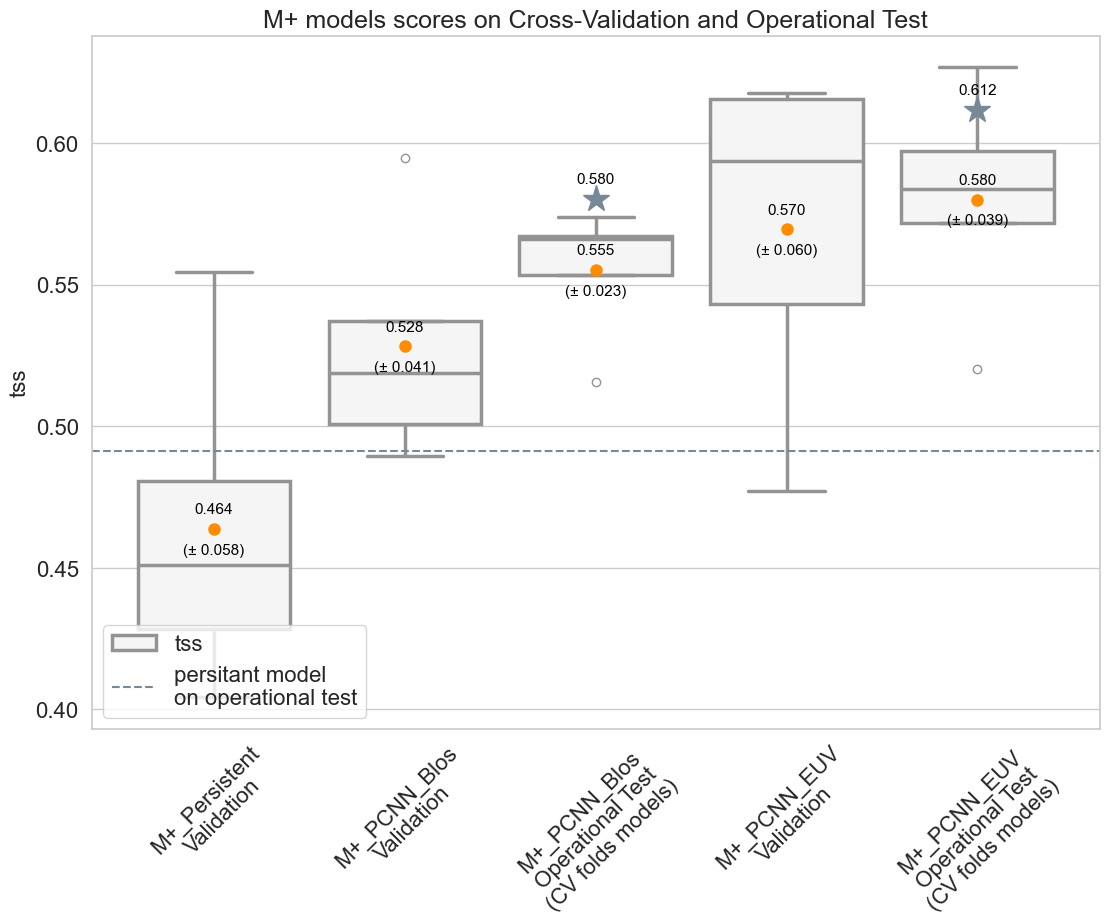

In [16]:
typeModel = 'M+'
metrics = ['tss']
palette = ['whitesmoke']

sns.set(style="whitegrid")

dfTemp = dfAll.copy()
dfTemp = dfAll[dfAll['model'].apply(lambda x: x.split('_')[0]==typeModel)]

plt.rcParams["figure.figsize"] = (13,9)
fontsize = 16
plt.rcParams['font.size'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize


cls = dfTemp['model'].reset_index()['model'][0][0]

dfTemp = dfTemp[dfTemp['metric'].isin(metrics)]

color = 'silver' # 'lightblue' 'cornflowerblue'

box_plot = sns.boxplot(x = 'model', y = 'performance', hue='metric',
            data = dfTemp[dfTemp['fold']!='avg'].sort_values(by=['order'], ascending = True),
            dodge=True,
            linewidth=2.5,
            palette= palette ,#"Blues",#
            # color = 'cornflowerblue',
            showmeans = True,
            meanprops={"marker":"o",
                      "markerfacecolor":"darkorange",
                      "markeredgecolor":"darkorange",
                      "markersize":"8"}
)

# for patch in box_plot.artists:
#   patch.set_facecolor('cornflowerblue')


for j,xtick in  enumerate(box_plot.get_xticks()):
  for idx, mtc in enumerate(metrics):
    # mtc = metrics[idx % len(metrics)]
    modelList = [m for m in list(modelOrder.keys()) if m.split('_')[0]==typeModel]
    tmp_all = dfTemp[(dfTemp['metric']==mtc) & (dfTemp['model']==modelList[j])]
    tmp = tmp_all[tmp_all['fold']!='avg']
    means = tmp.groupby(['model'])['performance'].mean()[0]#.sort_index(key=lambda x: x.map(modelsOrder))
    maxs = tmp.groupby(['model'])['performance'].max()#.sort_index(key=lambda x: x.map(modelsOrder))
    stds = tmp.groupby(['model'])['performance'].std()[0]#.sort_index(key=lambda x: x.map(modelsOrder))
    vertical_offset = 0.0055 #means * 0.02 # offset from median for display
    # vertical_offset = 0.0012
    # vertical_offset = 0.01
    x = 0
    if idx == 0:
      x = -x
    box_plot.text(j+x,
                  means + vertical_offset,
                  f'{means:.3f}',
                  horizontalalignment='center',
                  size='x-small',
                  color='black',
                  #weight='semibold'
                  )
    box_plot.text(j+x,
                  means - vertical_offset*1.6,
                  f'(± {stds:.3f})',
                  horizontalalignment='center',
                  size='x-small',
                  color='black',
                  #weight='semibold'
                  )
    vertical_offset = 0.007
    if j % 2 == 0 and j>0:
      if idx == 0:
        color = 'lightslategray'
        # box_plot.text(j+x,
        #           tmp_all[tmp_all['fold']=='avg']['performance'] - vertical_offset - 0.001,
        #           f'        Ensemble Model',
        #           horizontalalignment='center',
        #           size='x-small',
        #           color='black',
        #           #weight='semibold'
        #           )
      else:
        color = 'cornflowerblue'
      box_plot.plot(j+x, tmp_all[tmp_all['fold']=='avg']['performance'], marker='*', markersize=20, color = color)
      res = tmp_all[tmp_all['fold']=='avg']['performance'].values[0]
      box_plot.text(j+x,
                  tmp_all[tmp_all['fold']=='avg']['performance'] + vertical_offset - 0.0015,
                  f'{res:.3f}',
                  horizontalalignment='center',
                  size='x-small',
                  color='black',
                  #weight='semibold'
                  )

plt.xticks(rotation=45)
plt.title(f'{cls}+ Forecasts Cross-Validation and Operational Test', fontsize=fontsize+2)

# box_plot.set_ylim(bottom = 0.625, top = 0.755)
# box_plot.set_ylim(bottom = 0.55)
box_plot.set_xlabel('')
box_plot.set_ylabel(metrics[0])
plt.legend(loc='upper right')

# plt.axhline(perfs[(perfs.model=='M+_mpf_Persistent') & (perfs.modelFdId=='avg')]['tss'].values, color = 'red', linestyle = ':')
box_plot.axhline(perfs[(perfs.model==f'{cls}+_mpf_Persistent_24') & (perfs.modelFdId=='avg')][metrics[0]].values, color = color, linestyle = '--', label ='Persistent Operation Test')

# labels = [metrics[0], "persitant model\non operational test", "M+_Persistent\nOperational Test\n(tss & hss)"]
labels = [metrics[0], "persitant model\non operational test"]
handles, _ = box_plot.get_legend_handles_labels()

# Slice list to remove first handle

for patch in box_plot.artists:
  patch.set_facecolor('red')

plt.legend(handles = handles, labels = labels, loc = 'lower left')
# box_plot.axhline(perfs[(perfs.model=='M+_mpf_Persistent') & (perfs.modelFdId=='avg')]['tss'].values, color = 'red', linestyle = ':')

# plt.title(f'{cls}+ models {metrics[0]} scores on Cross-Validation and Operational Test', fontsize=fontsize+2)

plt.title(f'{cls}+ models scores on Cross-Validation and Operational Test', fontsize=fontsize+2)

### M+ -- HSS

/var/folders/2f/7x2b25l505v3y0t1yrc6rybm0000gn/T/ipykernel_5166/3125109936.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  means = tmp.groupby(['model'])['performance'].mean()[0]#.sort_index(key=lambda x: x.map(modelsOrder))
/var/folders/2f/7x2b25l505v3y0t1yrc6rybm0000gn/T/ipykernel_5166/3125109936.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stds = tmp.groupby(['model'])['performance'].std()[0]#.sort_index(key=lambda x: x.map(modelsOrder))
/var/folders/2f/7x2b25l505v3y0t1yrc6rybm0000gn/T/ipykernel_5166/3125109936.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a fut

Text(0.5, 1.0, 'M+ models scores on Cross-Validation and Operational Test')

/Users/greg/Projects/sundl/.conda/lib/python3.11/site-packages/matplotlib/text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
/Users/greg/Projects/sundl/.conda/lib/python3.11/site-packages/matplotlib/text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


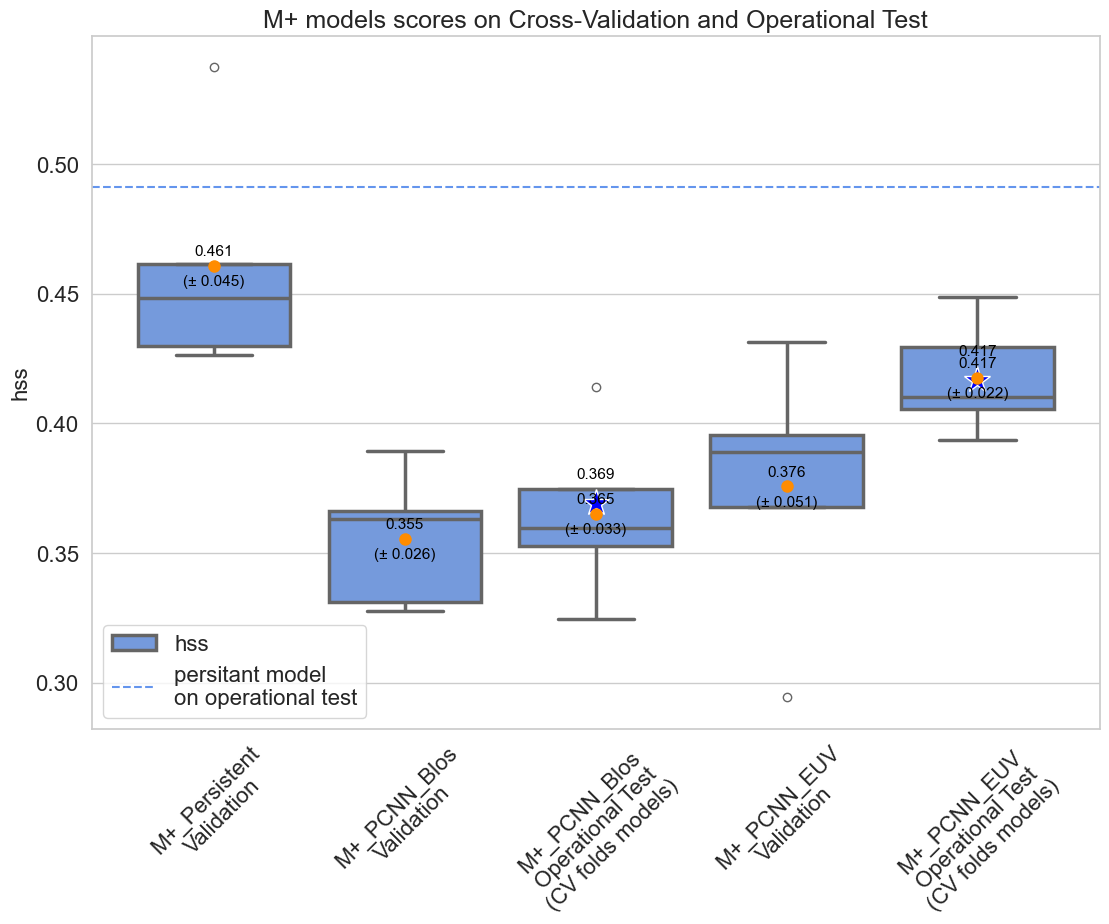

In [18]:
typeModel = 'M+'
metrics = ['hss']
palette = ['palette']
color = 'cornflowerblue' # 'lightblue' 'cornflowerblue'

sns.set(style="whitegrid")

dfTemp = dfAll.copy()
dfTemp = dfAll[dfAll['model'].apply(lambda x: x.split('_')[0]==typeModel)]

plt.rcParams["figure.figsize"] = (13,9)
fontsize = 16
plt.rcParams['font.size'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize


cls = dfTemp['model'].reset_index()['model'][0][0]

dfTemp = dfTemp[dfTemp['metric'].isin(metrics)]


box_plot = sns.boxplot(x = 'model', y = 'performance', hue='metric',
            data = dfTemp[dfTemp['fold']!='avg'].sort_values(by=['order'], ascending = True),
            dodge=True,
            linewidth=2.5,
            palette= sns.color_palette([color]) ,#"Blues",#
            # color = 'cornflowerblue',
            showmeans = True,
            meanprops={"marker":"o",
                      "markerfacecolor":"darkorange",
                      "markeredgecolor":"darkorange",
                      "markersize":"8"}
)

# for patch in box_plot.artists:
#   patch.set_facecolor('cornflowerblue')


for j,xtick in  enumerate(box_plot.get_xticks()):
  for idx, mtc in enumerate(metrics):
    modelList = [m for m in list(modelOrder.keys()) if m.split('_')[0]==typeModel]
    tmp_all = dfTemp[(dfTemp['metric']==mtc) & (dfTemp['model']==modelList[j])]
    tmp = tmp_all[tmp_all['fold']!='avg']
    means = tmp.groupby(['model'])['performance'].mean()[0]#.sort_index(key=lambda x: x.map(modelsOrder))
    maxs = tmp.groupby(['model'])['performance'].max()#.sort_index(key=lambda x: x.map(modelsOrder))
    stds = tmp.groupby(['model'])['performance'].std()[0]#.sort_index(key=lambda x: x.map(modelsOrder))
    vertical_offset = 0.004 #means * 0.02 # offset from median for display
    # vertical_offset = 0.0012
    # vertical_offset = 0.01
    x = 0
    if idx == 0:
      x = -x
    box_plot.text(j+x,
                  means + vertical_offset,
                  f'{means:.3f}',
                  horizontalalignment='center',
                  size='x-small',
                  color='black',
                  #weight='semibold'
                  )
    box_plot.text(j+x,
                  means - vertical_offset*1.9,
                  f'(± {stds:.3f})',
                  horizontalalignment='center',
                  size='x-small',
                  color='black',
                  #weight='semibold'
                  )
    vertical_offset = 0.0112
    if j % 2 == 0 and j>0:
      if idx == 0:
        color = 'cornflowerblue'
        # box_plot.text(j+x,
        #           tmp_all[tmp_all['fold']=='avg']['performance'] - vertical_offset - 0.001,
        #           f'        Ensemble Model',
        #           horizontalalignment='center',
        #           size='x-small',
        #           color='black',
        #           #weight='semibold'
        #           )
      else:
        color = 'cornflowerblue'
      box_plot.plot(j+x, tmp_all[tmp_all['fold']=='avg']['performance'], marker='*', markersize=20, color = 'blue',markeredgecolor='white')
      res = tmp_all[tmp_all['fold']=='avg']['performance'].values[0]
      box_plot.text(j+x,
                  tmp_all[tmp_all['fold']=='avg']['performance'] + vertical_offset - 0.0015,
                  f'{res:.3f}',
                  horizontalalignment='center',
                  size='x-small',
                  color='black',
                  #weight='semibold'
                  )

plt.xticks(rotation=45)
plt.title(f'{cls}+ Forecasts Cross-Validation and Operational Test', fontsize=fontsize+2)

# box_plot.set_ylim(bottom = 0.625, top = 0.755)
# box_plot.set_ylim(bottom = 0.55)
box_plot.set_xlabel('')

box_plot.set_ylabel(metrics[0])
plt.legend(loc='upper right')

# plt.axhline(perfs[(perfs.model=='M+_mpf_Persistent') & (perfs.modelFdId=='avg')]['tss'].values, color = 'red', linestyle = ':')
box_plot.axhline(perfs[(perfs.model==f'{cls}+_mpf_Persistent_24') & (perfs.modelFdId=='avg')][metrics[0]].values, color = color, linestyle = '--', label ='Persistent Operation Test')

# labels = [metrics[0], "persitant model\non operational test", "M+_Persistent\nOperational Test\n(tss & hss)"]
labels = [metrics[0], "persitant model\non operational test"]
handles, _ = box_plot.get_legend_handles_labels()

# Slice list to remove first handle

for patch in box_plot.artists:
  patch.set_facecolor('red')

plt.legend(handles = handles, labels = labels, loc = 'lower left')
# box_plot.axhline(perfs[(perfs.model=='M+_mpf_Persistent') & (perfs.modelFdId=='avg')]['tss'].values, color = 'red', linestyle = ':')

# plt.title(f'{cls}+ models {metrics[0]} scores on Cross-Validation and Operational Test', fontsize=fontsize+2)

plt.title(f'{cls}+ models scores on Cross-Validation and Operational Test', fontsize=fontsize+2)

## AC - Box plot

### AC Setup

In [19]:
metrics = ['tss','hss','mcc','f1']

modelOrder = {
              'C+_PCNN_Blos\nOperational Test\n(CV folds models)' : 0,
              'C+_PCNN_EUV\nOperational Test\n(CV folds models)' : 1,
              'M+_PCNN_Blos\nOperational Test\n(CV folds models)' : 2,
              'M+_PCNN_EUV\nOperational Test\n(CV folds models)' : 3,
              }
modelsBoxPlot = list(set([modelDictRev[model.split('\n')[0]] for model in modelOrder.keys()]))


# Dataframe for test bp
perfs = perfTest[perfTest['filter']=='windowChanging'].reset_index().copy()
perfs = perfs[perfs['startingDate']==perfs['startingDate'].min()]
dfBp = pd.DataFrame({col:[] for col in ['model', 'fold','performance', 'metric']})
for i in range(len(perfs)):
  for mtc in metrics:
    fold = perfs.loc[i,'modelFdId']
    model = perfs.loc[i,'model']
    if fold not in ['']:#['fd000']:
      perf = perfs.loc[i,mtc]
      tmp = pd.DataFrame({'model' : model,
                          'fold' : fold,
                          'performance' : perf,
                          'metric' : mtc
                          },index = [len(dfBp)])
      dfBp = pd.concat([dfBp,tmp],axis=0)

dfBp = dfBp[dfBp['model'].isin(modelsBoxPlot)]

# # Dataframe for val bp
# dfBp_val = {'model':[],
#             'performance' : [],
#             'metric' : [],
#             'fold' : []
#             }
# for modelName in modelsBoxPlot:
#   foldsPaths = sorted(glob((FOLDER/f'training_folds/training_{modelName}*').as_posix()))
#   for kf,fdPath in enumerate(foldsPaths):
#     for i,mtc in enumerate(metrics):
#       mtc = f'val_{mtc}'
#       tmp = pd.read_csv(fdPath)
#       tp = tmp['val_TP']
#       tn = tmp['val_TN']
#       fp = tmp['val_FP']
#       fn = tmp['val_FN']
#       tmp['val_mcc'] = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
#       dfBp_val['model'].append(modelName)
#       # print(dfBp_val['model'])
#       #dfBp[mtc1].append(np.max(tmp[mtc1]))
#       #dfBp[mtc2].append(tmp[mtc2].loc[np.argmax(tmp[mtc1])])
#       if i==0:
#         epc = np.argmax(tmp[mtc])
#         dfBp_val['performance'].append(np.max(tmp[mtc]))
#         # dfBp_val['epoch'].append(epc)
#       else:
#         dfBp_val['performance'].append(tmp[mtc].loc[epc])
#         # dfBp_val['epoch'].append(epc)
#       dfBp_val['metric'].append(mtc[4:])
#       dfBp_val['fold'].append(kf)
# dfBp_val = pd.DataFrame(dfBp_val)

# # for modelName in modelDict.keys():
# #   dfBp_val[dfBp_val['model'] == modelName]['model'] = modelDict[modelName] + '\nValidation'
# dfBp_val['model'] = dfBp_val['model'].apply(lambda x: modelDict[x] + '\nValidation')
# dfBp_val['fold'] = dfBp_val['fold'].apply(lambda x: str(x))
# # dfBp_val

# Merging Test and Val
dfTest = dfBp.copy()
dfTest = dfTest[~dfTest['model'].isin(['C+_mpf_Persistent_24', 'M+_mpf_Persistent_24'])]
dfTest['model'] = dfTest['model'].apply(lambda x: modelDict[x] + '\nOperational Test\n(CV folds models)')
cls = dfTest['model'].reset_index()['model'][0][0]

dfAll =   dfTest# pd.concat([dfBp_val,dfTest],axis=0)
dfAll['order'] = dfAll['model'].apply(lambda x: modelOrder[x])
dfAll = dfAll.sort_values(by=['order'], ascending = True)

dfAll = dfAll[dfAll['metric'].isin(metrics)]


### AC plot

/var/folders/2f/7x2b25l505v3y0t1yrc6rybm0000gn/T/ipykernel_5166/740597341.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  means = tmp.groupby(['model'])['performance'].mean()[0]#.sort_index(key=lambda x: x.map(modelsOrder))
/var/folders/2f/7x2b25l505v3y0t1yrc6rybm0000gn/T/ipykernel_5166/740597341.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stds = tmp.groupby(['model'])['performance'].std()[0]#.sort_index(key=lambda x: x.map(modelsOrder))
/var/folders/2f/7x2b25l505v3y0t1yrc6rybm0000gn/T/ipykernel_5166/740597341.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future

Text(0.5, 1.0, 'Models Operational Performances on Time Windows With Activity Change')

/Users/greg/Projects/sundl/.conda/lib/python3.11/site-packages/matplotlib/text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
/Users/greg/Projects/sundl/.conda/lib/python3.11/site-packages/matplotlib/text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


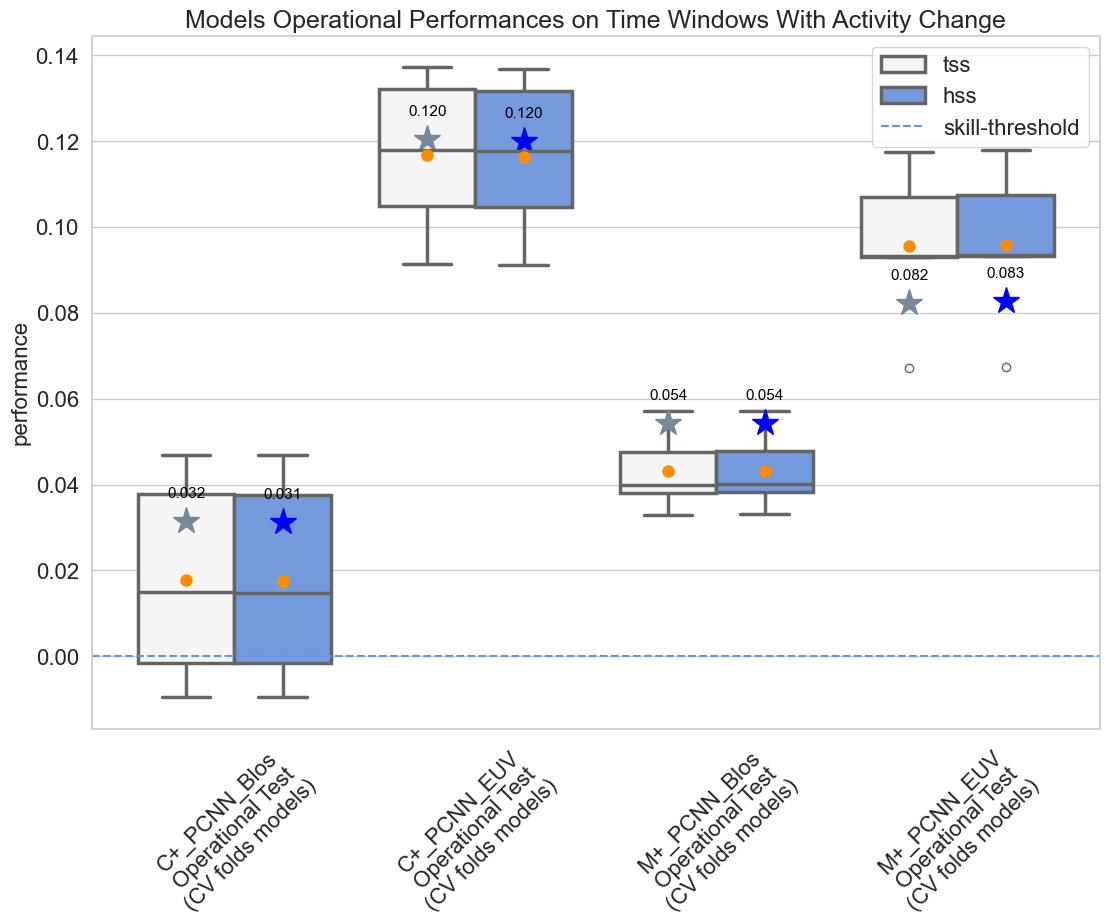

In [20]:
# typeModel = 'C+'
metrics = ['tss','hss']
palette= ['whitesmoke','cornflowerblue']

dfTemp = dfAll.copy()
# dfTemp = dfAll[dfAll['model'].apply(lambda x: x.split('_')[0]==typeModel)]


sns.set(style="whitegrid")

plt.rcParams["figure.figsize"] = (13,9)
fontsize = 16
plt.rcParams['font.size'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize


cls = dfTemp['model'].reset_index()['model'][0][0]

color = 'silver' # 'lightblue' 'cornflowerblue'

box_plot = sns.boxplot(x = 'model', y = 'performance', hue='metric',
            data = dfTemp[dfTemp['fold']!='avg'].sort_values(by=['order'], ascending = True),
            hue_order=metrics,
            dodge=True,
            linewidth=2.5,
            # palette= sns.color_palette([color]) ,#"Blues",#
            # color = 'cornflowerblue',
            palette= palette,
            showmeans = True,
            meanprops={"marker":"o",
                      "markerfacecolor":"darkorange",
                      "markeredgecolor":"darkorange",
                      "markersize":"8"}
)

for j,xtick in  enumerate(box_plot.get_xticks()):
  for idx, mtc in enumerate(metrics):
    # mtc = metrics[idx % len(metrics)]
    modelList = [m for m in list(modelOrder.keys())]# if m.split('_')[0]==typeModel]
    tmp_all = dfTemp[(dfTemp['metric']==mtc) & (dfTemp['model']==modelList[j])]
    tmp = tmp_all[tmp_all['fold']!='avg']
    means = tmp.groupby(['model'])['performance'].mean()[0]#.sort_index(key=lambda x: x.map(modelsOrder))
    maxs = tmp.groupby(['model'])['performance'].max()#.sort_index(key=lambda x: x.map(modelsOrder))
    stds = tmp.groupby(['model'])['performance'].std()[0]#.sort_index(key=lambda x: x.map(modelsOrder))
    vertical_offset = 0.0065 #means * 0.02 # offset from median for display
    # vertical_offset = 0.0012
    # vertical_offset = 0.01
    x = 0.2
    if idx == 0:
      x = -x
    # box_plot.text(j+x,
    #               means + vertical_offset,
    #               f'{means:.3f}',
    #               horizontalalignment='center',
    #               size='x-small',
    #               color='black',
    #               #weight='semibold'
    #               )
    # box_plot.text(j+x,
    #               means - vertical_offset*1.6,
    #               f'(± {stds:.3f})',
    #               horizontalalignment='center',
    #               size='x-small',
    #               color='black',
    #               #weight='semibold'
    #               )
    vertical_offset = 0.007
    # if j % 2 == 0 and j>0:
    if idx == 0:
      color = 'lightslategray'
      # box_plot.text(j+x,
      #           tmp_all[tmp_all['fold']=='avg']['performance'] - vertical_offset - 0.001,
      #           f'        Ensemble Model',
      #           horizontalalignment='center',
      #           size='x-small',
      #           color='black',
      #           #weight='semibold'
      #           )
    else:
      color = 'blue'
      
    box_plot.plot(j+x, tmp_all[tmp_all['fold']=='avg']['performance'], marker='*', markersize=20, color = color)
    
    res = tmp_all[tmp_all['fold']=='avg']['performance'].values[0]
    box_plot.text(j+x,
                tmp_all[tmp_all['fold']=='avg']['performance'] + vertical_offset - 0.0015,
                f'{res:.3f}',
                horizontalalignment='center',
                size='x-small',
                color='black',
                #weight='semibold'
                )

plt.xticks(rotation=45)
plt.title(f'{cls}+ Forecasts Cross-Validation and Operational Test', fontsize=fontsize+2)

# box_plot.set_ylim(bottom = 0.625, top = 0.755)
# box_plot.set_ylim(bottom = 0.55)
box_plot.set_xlabel('')
plt.legend(loc='upper right')

# plt.axhline(perfs[(perfs.model=='M+_mpf_Persistent') & (perfs.modelFdId=='avg')]['tss'].values, color = 'red', linestyle = ':')
box_plot.axhline(0.0, color = 'cornflowerblue', linestyle = '--', label ='skill-threshold')

# labels = [metrics[0], "persitant model\non operational test", "M+_Persistent\nOperational Test\n(tss & hss)"]
labels = [metrics[0], metrics[1], "skill-threshold"]
handles, _ = box_plot.get_legend_handles_labels()

# Slice list to remove first handle

for patch in box_plot.artists:
  patch.set_facecolor('red')

plt.legend(handles = handles, labels = labels, loc = 'upper right')
# box_plot.axhline(perfs[(perfs.model=='M+_mpf_Persistent') & (perfs.modelFdId=='avg')]['tss'].values, color = 'red', linestyle = ':')

# plt.title(f'{cls}+ models {metrics[0]} scores on Cross-Validation and Operational Test', fontsize=fontsize+2)

plt.title(f'Models Operational Performances on Time Windows With Activity Change', fontsize=fontsize+2)

In [ ]:
mtc, modelList[j], modelList

In [ ]:
dfTemp[(dfTemp['metric']==mtc) & (dfTemp['model']==modelList[j])]

In [ ]:
dfTemp

# Pathes Performances

## Patches' Labels Computation

In [21]:
%%time
from sundl.utils.flare.windows import windowHistoryFromFlList_ByPatchSector_EXACT

CORRECTED_SECTOR = True
window_h         = 24
timeRes_h        = 2
num_patches      = 8
path_label_ptchs = F_PATH_LABEL_PATCHES(num_patches, timeRes_h, window_h)

# Take a few minutes (~5) if not already saved
if path_label_ptchs.exists():
  with open(path_label_ptchs, 'rb') as f1:
    fl_historys = pickle.load(f1)
else:
  # Loading flare catalog with position
  nan_val = 9999.0
  flCatalog_positions = read_Dataframe_With_Dates(PATH_FLCATALOG_WITH_POS, ['timestamp','tstart'])
  with open(PATH_MISSING_POS_DATES, 'rb') as f1:
    missing_positions_events = pickle.load(f1)
  print('MISSING DATES : ',len(missing_positions_events))
  remove_date = flCatalog_positions[(flCatalog_positions.x == nan_val) | (flCatalog_positions.y == nan_val)]
  # missing_positions_events = missing_positions_events.append(remove_date.reset_index()['timestamp']).reset_index(drop=True)
  missing_positions_events = pd.concat([missing_positions_events,remove_date.reset_index()['timestamp']])
  print('after nan rmvl: ',len(missing_positions_events))
  # Computing sector-windows-history/features
  fl_historys = windowHistoryFromFlList_ByPatchSector_EXACT(
      flCatalog_positions,
      missing_positions_events,
      window_h = window_h, 
      timeRes_h = timeRes_h,
      minDate = datetime.datetime(2020,1,1), 
      maxDate = None, 
      num_patches = num_patches)
  with open(path_label_ptchs, 'wb') as f1:
    pickle.dump(fl_historys, f1)


CPU times: user 3.98 ms, sys: 30.7 ms, total: 34.7 ms
Wall time: 747 ms


## Load Patches Predictions

In [22]:
%%time
from sundl.utils.flare.thresholds import mpfTresh, totehTresh

window_h   = 24
labelCol   = 'mpf'


modelsNames = [modelDictRev['C+_PCNN_EUV'],
               modelDictRev['C+_PCNN_Blos'],
               modelDictRev['M+_PCNN_EUV'],
               modelDictRev['M+_PCNN_Blos'],
               'C+_PCNN_Both_Max',
               'M+_PCNN_Both_Max',
               'C+_PCNN_Both_Avg',
               'M+_PCNN_Both_Avg'
               ]


# ensModIsMax = True
ensembles = {'C+_PCNN_Both_Max'  : [modelDictRev['C+_PCNN_EUV'], modelDictRev['C+_PCNN_Blos']],
             'M+_PCNN_Both_Max'  : [modelDictRev['M+_PCNN_EUV'], modelDictRev['M+_PCNN_Blos']],
             'C+_PCNN_Both_Avg'  : [modelDictRev['C+_PCNN_EUV'], modelDictRev['C+_PCNN_Blos']],
             'M+_PCNN_Both_Avg'  : [modelDictRev['M+_PCNN_EUV'], modelDictRev['M+_PCNN_Blos']]
            #  'C+_PCNN_Histo' : [modelDictRev[c+_PCNN_EUV'], modelDictRev['C+_PCNN_Blos'] , modelDictRev['C+_Persistent']],
            #  'M+_PCNN_Histo' : [modelDictRev['M+_PCNN_EUV'], modelDictRev['M+_PCNN_Blos'] , modelDictRev['M+_Persistent']]
             }

ensembles = {}
modelsNames = list(modelDict.keys())

ptPredictions = {}

if labelCol == 'mpf':
  classTresholds = mpfTresh
elif labelCol == 'toteh':
  classTresholds = totehTresh[h]

for modelName in modelsNames:
  # pathPredPt =  pathPreds/f'{modelName}_pt.csv'
  pathPredPt_withLabels = F_PATH_PREDS_MODEL(F_PATH_PREDS(FOLDER), modelName, 'pt', True)
  if pathPredPt_withLabels.exists():
    ptPredictions[modelName] = read_Dataframe_With_Dates(pathPredPt_withLabels)
  else:
    pathPredPt = F_PATH_PREDS_MODEL(F_PATH_PREDS(FOLDER), modelName, 'pt', False)
    if modelName.split('_')[2]!='Persistent' and modelName.split('_')[0] in ['C+','M+']: # pathPredPt.exists() and # -->  pathPredPt must exists after notebook 3
      ptPredictions[modelName] = read_Dataframe_With_Dates(pathPredPt)
      # ptPredictions[modelName]['timestamp'] = ptPredictions[modelName]['timestamp'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S')) # '%Y/%m/%d/H%H00/
      # ptPredictions[modelName] = ptPredictions[modelName].set_index('timestamp',drop = True)
      if 'label' in ptPredictions[modelName].columns:
        ptPredictions[modelName] = ptPredictions[modelName].drop('label',axis=1)

      ptcPredCols = [col for col in ptPredictions[modelName].columns if len(col)==len('pred_pt0')]
      num_ptc = len(ptcPredCols)
      # fl_historys = windowHistoryFromFlList_ByPatchSector(window_h = window_h, timeRes_h = 2, minDate = datetime.datetime(2020,1,1), maxDate = maxDate, num_patches = num_ptc)

      for ptcId in range(num_ptc):
        histo = fl_historys[ptcId].copy()
        histo.index = histo.index + pd.DateOffset(hours= -window_h) # shifting history to window labels
        ptPredictions[modelName] = pd.concat([ptPredictions[modelName],
                                              histo[[labelCol]].rename(columns={labelCol:f'{labelCol}_pt{ptcId}'})
                                              ], axis=1, join="inner")
        cls = modelName[0]
        # @@@@@@@@@@@@ T
        ptPredictions[modelName][f'label_pt{ptcId}'] = ptPredictions[modelName][f'{labelCol}_pt{ptcId}'].apply(lambda x: x>=classTresholds[cls][0])

        ptPredictions[modelName][f'histo_pt{ptcId}'] = ptPredictions[modelName][f'label_pt{ptcId}'].rolling(window = f'{window_h}H',
                                          closed = 'right', # min_periods = int(input_lag)
                                          ).apply(
                                            lambda x: x[0])
        ptPredictions[modelName][f'change_pt{ptcId}'] = ptPredictions[modelName][f'histo_pt{ptcId}'] != ptPredictions[modelName][f'label_pt{ptcId}']
        ptPredictions[modelName][f't2f_pt{ptcId}'] = histo['t2mpf_h']
        ptPredictions[modelName][f'x_pt{ptcId}'] = histo['x']
        ptPredictions[modelName][f'y_pt{ptcId}'] = histo['y']
      pathPredPt_withLabels = F_PATH_PREDS_MODEL(F_PATH_PREDS(FOLDER), modelName, 'pt', True)
      ptPredictions[modelName].to_csv(pathPredPt_withLabels)
    
# Creating persistent predictions at patch level
for idx,modelName in enumerate([f'C+_{labelCol}_Persistent_{window_h}',f'M+_{labelCol}_Persistent_{window_h}']):
  pathPredPt_withLabels = F_PATH_PREDS_MODEL(F_PATH_PREDS(FOLDER), modelName, 'pt', True)
  if pathPredPt_withLabels.exists():
    ptPredictions[modelName] = read_Dataframe_With_Dates(pathPredPt_withLabels)
  else:
    cls = modelName[:2]
    tmp = ptPredictions[modelDictRev[f'{cls}_PCNN_EUV']].copy()
    ptcPredCols = [col for col in tmp.columns if len(col)==len('pred_pt0')]
    num_ptc = len(ptcPredCols)
    ptPredictions[modelName] = tmp[[col for col in tmp.columns if col[:3]!='pre']]
    # ptPredictions[modelName] = ptPredictions[modelName][[col for col in ptPredictions[modelName].columns if col[:3]!='lab']]
    for ptcId in range(num_ptc):
      ptPredictions[modelName][f'pred_pt{ptcId}'] = ptPredictions[modelName][f'histo_pt{ptcId}']
      # ptPredictions[modelName][f'label_pt{ptcId}'] = ptPredictions[modelName][f'histo_pt{ptcId}']
  # ptPredictions[list(ptPredictions.keys())[0]]
    pathPredPt_withLabels = F_PATH_PREDS_MODEL(F_PATH_PREDS(FOLDER), modelName, 'pt', True)
    ptPredictions[modelName].to_csv(pathPredPt_withLabels)



# modelsNames = modelsNames + list(ensembles.keys())

<timed exec>:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<timed exec>:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<timed exec>:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<timed exec>:68: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
<tim

CPU times: user 59.7 s, sys: 1.78 s, total: 1min 1s
Wall time: 1min 14s


## Compute Peformances

In [23]:
from utilsTest import patchesPerformance

startingDates = [datetime.datetime(2020,1,28)]
filterNames   = ['all','windowChanging', 'windowConstant']
includeFolds  = True

perfTestPtTot, perfTestByPatch = patchesPerformance(
    ptPredictions, 
    startingDates, 
    filterNames, 
    includeFolds)

/Users/greg/Projects/flare_limits_pcnn/utilsTest.py:277: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perfTestByPatch = pd.concat([perfTestByPatch,pd.DataFrame({'model':modelName,
/Users/greg/Projects/flare_limits_pcnn/utilsTest.py:342: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perfTestPtTot = pd.concat([perfTestPtTot,pd.DataFrame({'model':modelName,
/Users/greg/Projects/flare_limits_pcnn/utilsTest.py:257: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2*prec*rec / (prec+

### Standard Metrics

In [24]:
group = 'all' # @['all', 'limb', 'center']

viz = perfTestPtTot.copy()[(perfTestPtTot.modelFdId == 'avg') & (perfTestPtTot.group == group)]
viz = viz[viz['startingDate']==viz['startingDate'].min()]

# col = ['model', 'filter','tss', 'hss', 'f1', # 'modelFdId', 'group', 'thd'
#        'recall', 'far', 'mcc', 'acc_w', 'fssp', 'fssr', 'bal_pos', 'switch_rate'
# ]


col = ['filter','tss', 'hss', 'mcc', 'f1',  'recall', 'far', 'bal_pos', 'switch_rate', 'fssp', 'fssr' ,'acc_w']

# viz[viz['filter']=='all'].sort_values(['tss'], ascending = False)[col]

modelsTab = ['C+_Persistent' ,'C+_PCNN_EUV', 'C+_PCNN_Blos', #'C+_PCNN_Both_Avg', 'C+_PCNN_Both_Max',
             'M+_Persistent' ,'M+_PCNN_EUV', 'M+_PCNN_Blos', #'M+_PCNN_Both_Avg', 'M+_PCNN_Both_Max',
             ]
modelsTab =  [modelDictRev[m] for m in modelsTab]

viz[viz['filter']=='all'].set_index('model').loc[modelsTab,col]

,filter,tss,hss,mcc,f1,recall,far,bal_pos,switch_rate,fssp,fssr,acc_w
model,,,,,,,,,,,,
C+_mpf_Persistent_24,all,0.595994,0.596040,0.589192,0.669934,0.669867,0.329998,0.182944,0.120755,-0.000049,0.549168,0.797997
C+_mpf_jpg_PTx8_RtdXall_EquiC_AW1e5D1e4_0193x0211x0094_24,all,0.501042,0.570280,0.602775,0.634316,0.535084,0.221268,0.182944,0.120755,-0.053214,0.500516,0.750521
C+_mpf_jpg_PTx8_RtdXall_EquiC_AW1e5D1e4_blos_24,all,0.389266,0.478278,0.549322,0.545979,0.412814,0.194034,0.191554,0.126535,-0.184759,0.372039,0.694633
M+_mpf_Persistent_24,all,0.380478,0.373250,0.458449,0.385531,0.393146,0.621795,0.019223,0.024091,0.019370,0.361907,0.690239
M+_mpf_jpg_PTx8_RtdXall_LowC2_AW1e5D1e4_0193x0211x0094_24,all,0.515879,0.276037,0.357254,0.296493,0.559257,0.798283,0.019223,0.024091,-0.205952,0.269445,0.757939
M+_mpf_jpg_PTx8_RtdXall_LowC2_AW1e5D1e4_blos_24,all,0.430431,0.224470,0.230389,0.247733,0.479829,0.833031,0.020218,0.025255,-0.340108,0.217315,0.715215


### AC - metrics

In [26]:
viz[viz['filter']=='windowChanging'].set_index('model').loc[modelsTab,col]

,filter,tss,hss,mcc,f1,recall,far,bal_pos,switch_rate,fssp,fssr,acc_w
model,,,,,,,,,,,,
C+_mpf_Persistent_24,windowChanging,-1.000000,-1.000000,-1.000000,NaN,0.000000,1.000000,0.500152,1.0,NaN,NaN,0.000000
C+_mpf_jpg_PTx8_RtdXall_EquiC_AW1e5D1e4_0193x0211x0094_24,windowChanging,0.013049,0.013047,-0.053218,0.316618,0.228602,0.485159,0.500152,1.0,0.316411,-0.366861,0.506525
C+_mpf_jpg_PTx8_RtdXall_EquiC_AW1e5D1e4_blos_24,windowChanging,0.014885,0.014886,-0.035848,0.234351,0.150766,0.474074,0.499962,1.0,0.234409,-0.531280,0.507442
M+_mpf_Persistent_24,windowChanging,-1.000000,-0.998015,-1.000000,NaN,0.000000,1.000000,0.484239,1.0,NaN,NaN,0.000000
M+_mpf_jpg_PTx8_RtdXall_LowC2_AW1e5D1e4_0193x0211x0094_24,windowChanging,0.018535,0.018589,0.144205,0.470152,0.447843,0.505199,0.484239,1.0,0.486855,-0.044392,0.509268
M+_mpf_jpg_PTx8_RtdXall_LowC2_AW1e5D1e4_blos_24,windowChanging,0.061704,0.062018,0.024615,0.474068,0.433386,0.476821,0.484802,1.0,0.490054,-0.037003,0.530852


### NC - meetrics

In [27]:
viz[viz['filter']=='windowConstant'].set_index('model').loc[modelsTab,col]

,filter,tss,hss,mcc,f1,recall,far,bal_pos,switch_rate,fssp,fssr,acc_w
model,,,,,,,,,,,,
C+_mpf_Persistent_24,windowConstant,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.139379,0.0,0.000000,1.000000,1.000000
C+_mpf_jpg_PTx8_RtdXall_EquiC_AW1e5D1e4_0193x0211x0094_24,windowConstant,0.666564,0.725237,0.768967,0.759441,0.686128,0.149704,0.139379,0.0,-0.240559,0.692384,0.833282
C+_mpf_jpg_PTx8_RtdXall_EquiC_AW1e5D1e4_blos_24,windowConstant,0.528024,0.625530,0.707871,0.667772,0.542034,0.130534,0.146876,0.0,-0.332228,0.570180,0.764012
M+_mpf_Persistent_24,windowConstant,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.007744,0.0,0.000000,1.000000,1.000000
M+_mpf_jpg_PTx8_RtdXall_LowC2_AW1e5D1e4_0193x0211x0094_24,windowConstant,0.692808,0.209351,0.326335,0.219756,0.731235,0.870692,0.007744,0.0,-0.780244,0.207672,0.846404
M+_mpf_jpg_PTx8_RtdXall_LowC2_AW1e5D1e4_blos_24,windowConstant,0.506083,0.145153,0.174468,0.157145,0.551143,0.908363,0.008180,0.0,-0.842855,0.143355,0.753041
